## Stable Diffusion XL1.0 fine tune with Lora in DreamBooth method
> Decoupled training job, training used seperated SageMaker training job
* This is an experiment for fine tune SD-XL-v1.0 with Kohya-ss unpublished sd-scripts.
* Character(Person) training example.
* ml.t3.medium notebook instance is good enough to run codes, configure storage with 150GB+, because we need to build large docker images for training job.
* Scripts and codes use [kohya-ss/sd-scripts](https://github.com/kohya-ss/sd-scripts).
* Training images come from [here](https://github.com/shirayu/example_lora_training).
* Lora training is basing on the method of DreamBooth+Caption(without using class_images to aviod over-fitting). 
* Besides the way of DreamBooth+Caption, Lora can also use other methods, such as DreamBooth+identifier+class and classic text2image fine tuning. Detailed info you can refer to https://github.com/darkstorm2150/sd-scripts/blob/main/docs/train_README-en.md
* If you can read Chinese and feel hard to dig info from kohya-ss repo, you can map the content from [Akegarasu repo](https://github.com/Akegarasu/lora-scripts) to kohya-ss for better understanding


# Fine tune model

## 1. Prepare training dataset

In [ ]:
!mkdir lora-training
%cd lora-training/

TRAIN_DATA_DIR = "./images"
DOCKER_FILE_DIR = "./dockerfile"
!mkdir -p $TRAIN_DATA_DIR $DOCKER_FILE_DIR

In [ ]:
!git clone https://github.com/terrificdm/dreambooth-stablediffusion-sagemaker-notebook
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/Wikipe-tan/* $TRAIN_DATA_DIR
!rm -rf dreambooth-stablediffusion-sagemaker-notebook

## 2. Prepare training config files and Dockerfile(docker image for training job)

Refer "dataset-example.toml" to configure your own .toml file

In [ ]:
%%writefile ./images/dataset.toml
[general]
enable_bucket = true
shuffle_caption = true
caption_extension = '.txt'
keep_tokens = 0

# DreamBooth caption based character datasets
[[datasets]]
resolution = 1024
# min_bucket_reso = 640
# max_bucket_reso = 1536
# bucket_reso_steps = 32
batch_size = 2

  [[datasets.subsets]]
  image_dir = '/opt/ml/input/data/images'
  num_repeats = 10

In [ ]:
%%writefile ./images/sample_prompt.toml
[prompt]
negative_prompt = "ugly, disfigured, deformed"
scale = 7
sample_steps = 20
width = 1024
height = 1024

[[prompt.subset]]
prompt = "wta, 1girl, looking_at_viewer, blue_hair, short_twintails, hair_ornament, blue_eyes, blush, smile, open_mouth, shirt, skirt, kneehighs, brown_footwear, standing, solo"
seed = 3129467234
[[prompt.subset]]
prompt = "wta, 1girl, looking_at_viewer, blue_hair, short_twintails, hair_ornament, blue_eyes, blush, smile, open_mouth, shirt, skirt, kneehighs, brown_footwear, standing, solo"
seed = 3129467235

In [ ]:
%%writefile ./dockerfile/Dockerfile
FROM 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:2.0.1-gpu-py310-cu118-ubuntu20.04-sagemaker

ENV PATH="/opt/ml/code:${PATH}"
ENV SAGEMAKER_SUBMIT_DIRECTORY /opt/ml/code
ENV DEBIAN_FRONTEND noninteractive

RUN git clone -b sdxl https://github.com/kohya-ss/sd-scripts /opt/ml/code

WORKDIR /opt/ml/code

RUN mv sdxl_train_network.py sdxl_train_network && \
    sed -i 's/tensorboard==2.10.1/tensorboard==2.14.0/g;' requirements.txt && \
    sed -i '/opencv/d' requirements.txt && \
    sed -i 's/-e \./\./g' requirements.txt && \
    pip install -U -r requirements.txt && \
    pip install xformers==0.0.20 wandb prodigyopt

# RUN mkdir -p images/

# COPY ./images/* ./images/

WORKDIR /

ENV SAGEMAKER_PROGRAM accelerate.commands.launch sdxl_train_network

## 3. Change default docker-root-dir of SageMaker notebook
> Default docker-root-dir of SageMaker notebook has limited space, which is not big enough for building large images

In [ ]:
!sudo service docker stop
!mkdir -p ~/SageMaker/docker-root
!sudo mv /var/lib/docker ~/SageMaker/docker-root
!sudo ln -s ~/SageMaker/docker-root/docker /var/lib/docker
!sudo service docker start

## 4. Build docker image and push to ECR

In [ ]:
%%sh

# Specify an algorithm name
algorithm_name=sdxl-lora-db-finetuning-job

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"
base_image_repo="763104351884.dkr.ecr.${region}.amazonaws.com"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1
if [ $? -ne 0 ]
then
aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly

aws ecr get-login-password --region ${region}|docker login --username AWS --password-stdin ${fullname}
aws ecr get-login-password --region ${region}|docker login --username AWS --password-stdin ${base_image_repo}

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build -t ${algorithm_name} ./dockerfile
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

## 5. Train models with SageMaker training job

In [8]:
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = boto3.session.Session().region_name
images_s3uri = 's3://{0}/sdxl-lora-train-dataset/images/'.format(bucket)

In [ ]:
# Copy training dataset to S3 bucket

!aws s3 cp images $images_s3uri --recursive

In [ ]:
import json
def json_encode_hyperparameters(hyperparameters):
    for (k, v) in hyperparameters.items():
        print(k, v)
    return {k: json.dumps(v) for (k, v) in hyperparameters.items()}

docker_image_uri = '{0}.dkr.ecr.{1}.amazonaws.com/sdxl-lora-db-finetuning-job'.format(account_id, region_name)
instance_type = 'ml.g5.2xlarge'

base_model_name="stabilityai/stable-diffusion-xl-base-1.0"
output_dir="/opt/ml/model/"

hyperparameters = {
                    'pretrained_model_name_or_path': base_model_name,
                    'dataset_config': '/opt/ml/input/data/images/dataset.toml',
                    'output_dir': output_dir,
                    'output_name': 'lora_wta',
                    'network_module': 'networks.lora',
                    'max_train_epochs': 10,
                    'network_train_unet_only': '',
                    'learning_rate': 1.0,
                    'lr_scheduler': 'cosine_with_restarts',
                    'lr_scheduler_num_cycles': 1,
                    'network_dim': 64,
                    'network_alpha': 32,
                    'save_every_n_epochs': 2,
                    'mixed_precision': 'bf16',
                    'full_bf16': '',
                    'gradient_checkpointing': '',
                    'max_token_length': 225,
                    'save_model_as': 'safetensors',
                    'no_half_vae': '',
                    'xformers': '',
                    'optimizer_type': 'prodigy',
                    'min_snr_gamma': 5,
                    'sample_every_n_epochs': 2,
                    'sample_prompts': '/opt/ml/input/data/images/sample_prompt.toml',
                    'sample_sampler': 'euler_a',
                    'logging_dir': '/opt/ml/code/logs',
                    'log_with': 'all',
                    'log_tracker_name': 'lora_wta',
                    'wandb_api_key': '7db8cd064c658320a9abc5943c22e092ef8c06a9'
}

hyperparameters = json_encode_hyperparameters(hyperparameters)

In [ ]:
from sagemaker.estimator import Estimator

inputs = {
    'images': images_s3uri
}

estimator = Estimator(
    role = role,
    instance_count=1,
    instance_type = instance_type,
    image_uri = docker_image_uri,
    hyperparameters = hyperparameters,
    disable_output_compression = True
)
estimator.fit(inputs)

In [ ]:
model_data = estimator.model_data
model_s3_path = model_data['S3DataSource']['S3Uri']
print("Model artifact saved at:", "\n"+model_s3_path+"\n")
!aws s3 ls {model_s3_path}

In [ ]:
# You can change the applied lora weight by changing lora weight name

lora_s3_path = model_s3_path + 'lora_wta.safetensors'
print ("Lora weight is saved at:", "\n"+lora_s3_path)

# Deploy model to SageMaker endpoint

## 1. Initialize SageMaker inference endpoint

In [14]:
import boto3
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = boto3.session.Session().region_name

## 2. Create "inference.py" script for SageMaker

In [15]:
!mkdir -p ./model/code

In [ ]:
%%writefile ./model/code/requirements.txt
diffusers>=0.19.3
invisible_watermark
safetensors

In [ ]:
%%writefile ./model/code/inference.py
# Inference code example for sdxl-v1.0

import base64
import torch
import boto3
import os
from botocore.exceptions import ClientError
from io import BytesIO
from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler

s3 = boto3.client('s3')

def check_file_existence(s3_path):
    bucket_name = s3_path.split("//")[1].split("/")[0]
    object_key = "/".join(s3_path.split("//")[1].split("/")[1:])
    try:
        s3.head_object(Bucket=bucket_name, Key=object_key)
        return True
    except ClientError as e:
        if e.response['Error']['Code'] == '404':
            return False
        else:
            raise

            
def download_file(s3_path):
    file_path = os.path.join("/tmp/", os.path.basename(s3_path))
    if os.path.exists(file_path):
        print("File already exists locally. Skipping download.")
        return file_path
    if check_file_existence(s3_path):
        bucket_name = s3_path.split("//")[1].split("/")[0]
        object_key = "/".join(s3_path.split("//")[1].split("/")[1:])
        s3.download_file(bucket_name, object_key, file_path)
        return file_path
    else:
        raise ValueError('File does not exist. Upload files to S3 first!')
        

def model_fn(model_dir):
    base_model = "stabilityai/stable-diffusion-xl-base-1.0"

    scheduler = EulerAncestralDiscreteScheduler.from_pretrained(base_model, subfolder="scheduler")
    base_pipe = DiffusionPipeline.from_pretrained(
        base_model,
        scheduler=scheduler,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
        cache_dir="/tmp/",
    ).to("cuda")
    
    return base_pipe


def encode_image(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    encoded_image_response = base64.b64encode(buffered.getvalue()).decode()
    return encoded_image_response


def predict_fn(data, base_pipe):
    generator = torch.Generator(device="cuda")
    use_refiner = data.pop("refiner", "")
    high_noise_frac = data.pop("high_noise_frac", 0.8)
    prompt = data.pop("prompt", "")
    negative_prompt = data.pop("negative_prompt", "")
    height = data.pop("height", 1024)
    width = data.pop("width", 1024)
    num_inference_steps = data.pop("num_inference_steps", 20)
    guidance_scale = data.pop("guidance_scale", 7)
    num_images_per_prompt = data.pop("num_images_per_prompt", 2)
    seed = data.pop("seed", "")
    lora_s3_path = data.pop("lora_s3_path", "")

    seeds = []
    encoded_images = []

    if seed:
        seeds = [seed + i for i in range(num_images_per_prompt)]
    else:
        seeds = [generator.seed() for _ in range(num_images_per_prompt)]

    for current_seed in seeds:
        generator.manual_seed(current_seed)
        base_pipe = base_pipe
        
        if lora_s3_path:
            lora_weight_path = download_file(lora_s3_path)
            base_pipe.load_lora_weights(lora_weight_path, low_cpu_mem_usage=True)
        else:
            base_pipe.unload_lora_weights()
            
        if use_refiner == "enable":
            notification = "SDXL refiner model is enabled!"
            
            refiner_model = "stabilityai/stable-diffusion-xl-refiner-1.0"
            refiner_pipe = DiffusionPipeline.from_pretrained(
                refiner_model,
                text_encoder_2=base_pipe.text_encoder_2,
                vae=base_pipe.vae,
                torch_dtype=torch.float16,
                use_safetensors=True,
                variant="fp16",
                cache_dir="/tmp/",
            ).to("cuda")    
            generated_images = base_pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                denoising_end=high_noise_frac,
                generator=generator,
                output_type="latent",
            ).images
            generated_images = refiner_pipe(
                prompt=prompt,
                num_inference_steps=num_inference_steps,
                denoising_start=high_noise_frac,
                image=generated_images,
            ).images[0]
        else:
            notification = "SDXL refiner model is disabled!"
            
            generated_images = base_pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator
            ).images[0]

        encoded_image_rt = encode_image(generated_images)
        encoded_images.append(encoded_image_rt)

    return {"notification": notification, "generated_images": encoded_images, "seeds": seeds}

## 3. Package model and upload to S3 bucket

In [ ]:
from sagemaker.s3 import S3Uploader

!tar --use-compress-program=pigz -pcvf ./model/model.tar.gz -C ./model/ .
s3_model_uri=S3Uploader.upload(local_path="./model/model.tar.gz", desired_s3_uri=f"s3://{sagemaker_session.default_bucket()}/model_deploy_code/sdxl_lora")

## 4. Deploy model by real-time inference endpoint

In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,      # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.28.1",  # transformers version used
   pytorch_version="2.0.0",       # pytorch version used
   py_version='py310',            # python version used
)

# deploy the endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g5.2xlarge"
    )

In [20]:
from PIL import Image
from io import BytesIO
import base64
import datetime

# helper decoder
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)


Notification: SDXL refiner model is enabled!



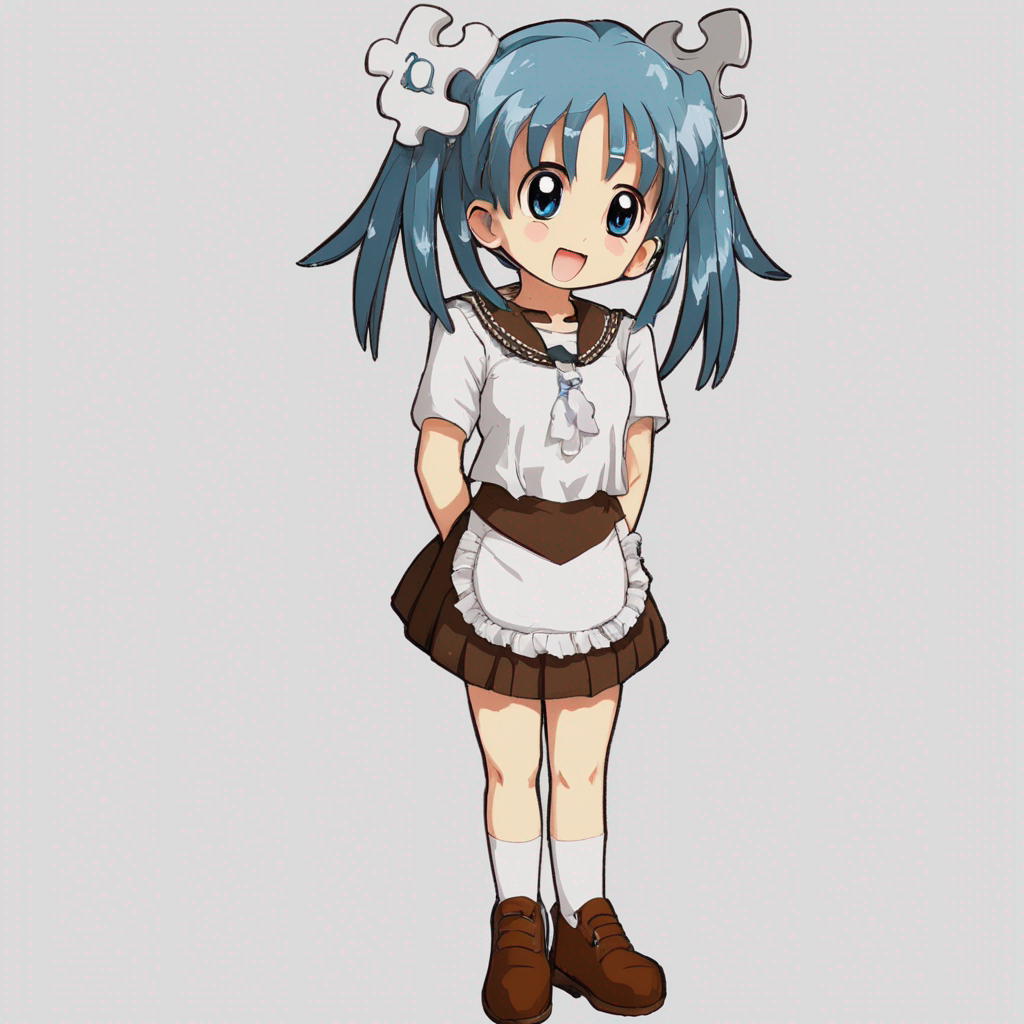

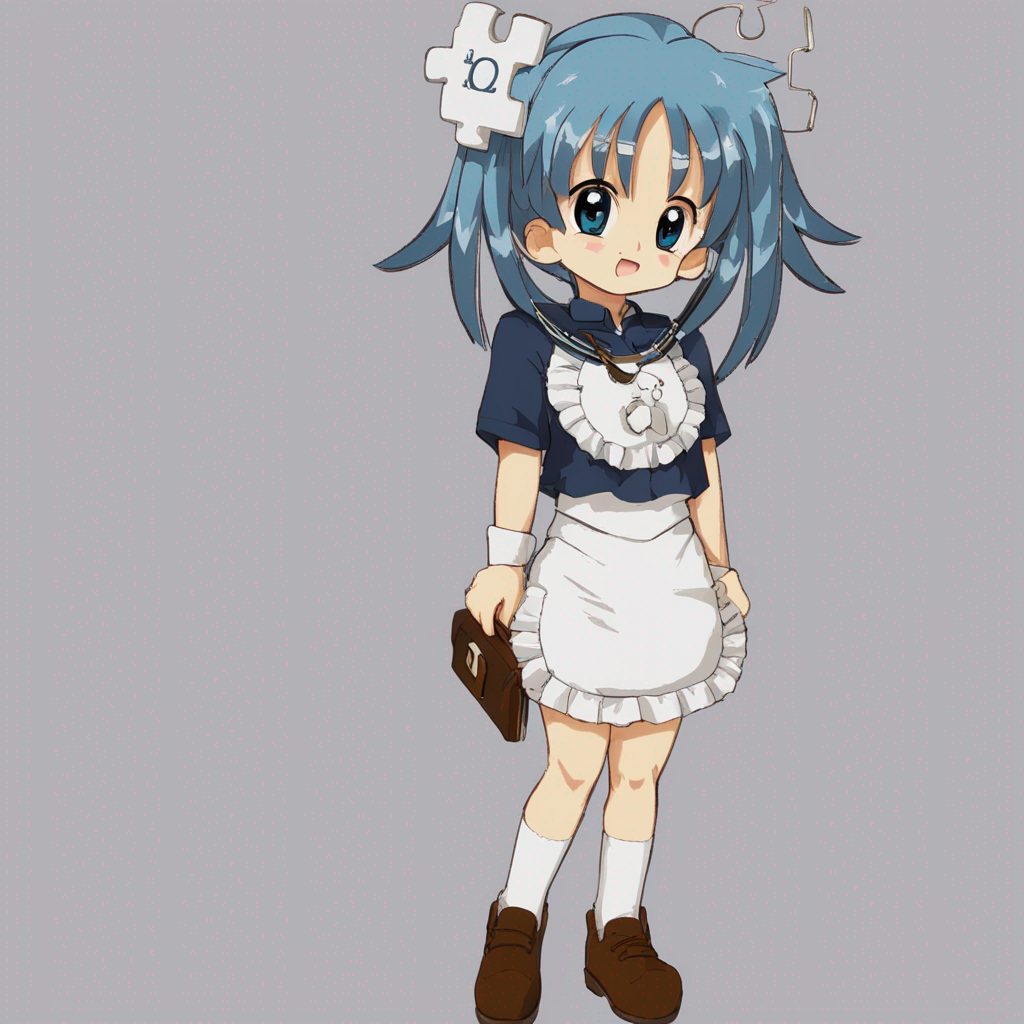


Seeds for generating images: [7239340432433747, 5406495829059005]


In [21]:
# run prediction
response = predictor.predict(data={
    "prompt": "wta, 1girl, looking_at_viewer, blue_hair, short_twintails, hair_ornament, blue_eyes, blush, smile, open_mouth, shirt, skirt, kneehighs, brown_footwear, standing, solo, ultra quality, highly detailed",
    "negative_prompt": "extra limbs, deformed, disfigured, ugly, bad",
    "height": 1024,
    "width": 1024,
    "num_images_per_prompt": 2,
    "refiner": "enable",
    "high_noise_frac": 0.8,
    "lora_s3_path": lora_s3_path, # You can change s3 url of the lora model in dynamic
    # "seed" : 860105273202351  # uncomment seed and replace with generated one, if you want to produce same
  }
)

print(f"\nNotification: {response['notification']}\n")

# decode images
decoded_images = [decode_base64_image(image) for image in response["generated_images"]]

# visualize generation
i = 0
for image in decoded_images:
    display(image)
    seed = response['seeds'][i]
    i = i+1
    
# print(seeds)
print(f"\nSeeds for generating images: {response['seeds']}")

## 5. Delete model and real-time endpoint 

In [22]:
# uncomment below codes if you wanto to delete mode and endpoint for inference

# predictor.delete_model()
# predictor.delete_endpoint()